In [118]:
import pandas as pd
import numpy as np
import seaborn as sb
import copy
import pandas_profiling
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder as ohe, LabelEncoder as le
import warnings
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report as cr
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [16]:
df = pd.read_csv('forModel.csv')

In [120]:
df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location,season,avg_high_temp (C),avg_low_temp (C),avg_precipitation (inches),snow (inches),unemployement_rate,Day,Night
0,I192068249,intermediate_crime,other,threats to do bodily harm,B2,280,0,2015-08-28,2015,8,Friday,10,Part Two,washington st,42.330119,-71.084251,"(42.33011862, -71.08425106)",summer,26.444444,-3.086420,1.58,0.0,0.0,1,0
1,I192061894,intermediate_crime,confidence games,fraud - credit card / atm fraud,C11,356,0,2015-08-20,2015,8,Thursday,0,Part Two,charles st,42.300605,-71.061268,"(42.30060543, -71.06126785)",summer,26.444444,-3.086420,1.58,0.0,0.0,0,1
2,I192038828,intermediate_crime,fraud,fraud - impersonation,A1,172,0,2015-11-02,2015,11,Monday,12,Part Two,albany st,42.334288,-71.072395,"(42.33428841, -71.07239518)",fall,10.722222,-11.820988,1.80,1.3,3.7,1,0
3,I192008877,intermediate_crime,fraud,fraud - impersonation,E18,525,0,2015-07-31,2015,7,Friday,10,Part Two,wingate rd,42.237009,-71.129566,"(42.23700950, -71.12956606)",summer,26.666667,-2.962963,4.03,0.0,0.0,1,0
4,I182090828,intermediate_crime,fraud,fraud - false pretense / scheme,D4,159,0,2015-12-01,2015,12,Tuesday,12,Part Two,upton st,42.342432,-71.072258,"(42.34243222, -71.07225766)",winter,2.555556,-16.358025,2.49,9.2,3.7,1,0


In [18]:
df.shape

(581169, 25)

In [19]:
df.season.unique()

array(['summer', 'fall', 'winter', 'spring'], dtype=object)

In [20]:
partOne = list(set(df.groupby('ucr_part').get_group('Part One')['offense_code']))
partTwo = list(set(df.groupby('ucr_part').get_group('Part Two')['offense_code']))
partThree = list(set(df.groupby('ucr_part').get_group('Part Three')['offense_code']))
partOther = list(set(df.groupby('ucr_part').get_group('Other')['offense_code']))

In [23]:
for i in tqdm(df.index):
    if df['offense_code'][i] in partOne:
        df['offense_code'][i] = 'serious_crime'
    elif df['offense_code'][i] in partTwo:
        df['offense_code'][i] = 'intermediate_crime'
    elif df['offense_code'][i] in partThree:
        df['offense_code'][i] = 'low_level_crime'
    elif df['offense_code'][i] in partOther:
        df['offense_code'][i] = 'other_crime'

100%|███████████████████████████████████████████████████████████████████████| 581169/581169 [00:11<00:00, 49006.05it/s]


In [25]:
df['unemployement_rate'].nunique()

16

##  We will trying predict how much case will occur a day.

## We will create with dataframe included district, occured on date, incident number (counted by days& district),day of week for modelling.

## If we add the Ucr_part and Hour features, they do not increase the score of our model. We do not include these to reduce complexity.


In [138]:
df_reg = pd.DataFrame(df.groupby(["occurred_on_date","district", "day_of_week"])["incident_number"].count()).reset_index()
df_reg.head()



,occurred_on_date,district,day_of_week,incident_number
0,2015-06-15,A1,Monday,23
1,2015-06-15,A15,Monday,5
2,2015-06-15,A7,Monday,10
3,2015-06-15,B2,Monday,34
4,2015-06-15,B3,Monday,26


In [139]:
df_reg.day_of_week.nunique()

7

In [140]:
df_reg.isnull().sum()

occurred_on_date    0
district            0
day_of_week         0
incident_number     0
dtype: int64

In [50]:
df_reg.head()

,occurred_on_date,district,day_of_week,case_count
0,2015-06-15,A1,1,23
1,2015-06-15,A15,1,5
2,2015-06-15,A7,1,10
3,2015-06-15,B2,1,34
4,2015-06-15,B3,1,26


In [141]:
df_reg.rename(columns = {'incident_number' : 'case_count'}, inplace = True)

In [142]:
df_reg['day_of_week'] = df_reg['day_of_week'].map({'Monday' : 1,
                                                  'Tuesday' : 2,
                                                  'Wednesday':3,
                                                  'Thursday' : 4,
                                                  "Friday" : 5,
                                                  'Saturday' : 6,
                                                  'Sunday' : 7})

In [143]:
df_reg = pd.concat([df_reg, pd.get_dummies(df_reg['district'], prefix = 'D')]
                   , axis = 1)

In [144]:
df_reg = pd.concat([df_reg, pd.get_dummies(df_reg['day_of_week'], prefix = 'day')]
                   , axis = 1)

In [145]:
df_reg.drop('district', axis = 1, inplace = True)

In [146]:
df_reg.drop('day_of_week', axis = 1, inplace = True)

In [147]:
df_reg

,occurred_on_date,case_count,D_A1,D_A15,D_A7,D_B2,D_B3,D_C11,D_C6,D_D14,D_D4,D_E13,D_E18,D_E5,D_External,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,2015-06-15,23,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2015-06-15,5,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2015-06-15,10,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2015-06-15,34,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2015-06-15,26,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31830,2022-08-30,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
31831,2022-08-30,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
31832,2022-08-30,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
31833,2022-08-30,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [148]:
df_reg["D_A1"] = np.int64(df_reg["D_A1"])
df_reg["D_A15"] = np.int64(df_reg["D_A15"])
df_reg["D_A7"] = np.int64(df_reg["D_A7"])
df_reg["D_B2"] = np.int64(df_reg["D_B2"])
df_reg["D_B3"] = np.int64(df_reg["D_B3"])
df_reg["D_C11"] = np.int64(df_reg["D_C11"])
df_reg["D_C6"] = np.int64(df_reg["D_C6"])
df_reg["D_D14"] = np.int64(df_reg["D_D14"])
df_reg["D_D4"] = np.int64(df_reg["D_D4"])
df_reg["D_E13"] = np.int64(df_reg["D_E13"])
df_reg["D_E18"] = np.int64(df_reg["D_E18"])
df_reg["D_E5"] = np.int64(df_reg["D_E5"])
df_reg["D_External"] = np.int64(df_reg["D_External"])


In [149]:
df_reg["day_1"] = np.int64(df_reg["day_1"])
df_reg["day_2"] = np.int64(df_reg["day_2"])
df_reg["day_3"] = np.int64(df_reg["day_3"])
df_reg["day_4"] = np.int64(df_reg["day_4"])
df_reg["day_5"] = np.int64(df_reg["day_5"])
df_reg["day_6"] = np.int64(df_reg["day_6"])
df_reg["day_7"] = np.int64(df_reg["day_7"])

In [150]:
df_reg['occurred_on_date'] = pd.to_datetime(df_reg['occurred_on_date'])

In [151]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31835 entries, 0 to 31834
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   occurred_on_date  31835 non-null  datetime64[ns]
 1   case_count        31835 non-null  int64         
 2   D_A1              31835 non-null  int64         
 3   D_A15             31835 non-null  int64         
 4   D_A7              31835 non-null  int64         
 5   D_B2              31835 non-null  int64         
 6   D_B3              31835 non-null  int64         
 7   D_C11             31835 non-null  int64         
 8   D_C6              31835 non-null  int64         
 9   D_D14             31835 non-null  int64         
 10  D_D4              31835 non-null  int64         
 11  D_E13             31835 non-null  int64         
 12  D_E18             31835 non-null  int64         
 13  D_E5              31835 non-null  int64         
 14  D_External        3183

In [152]:
# since linear regression model does not take datetime data type as input so we will convert it to gregorian number.
df_reg['occurred_on_date'] = df_reg['occurred_on_date'].apply(lambda x: x.toordinal())

In [153]:
df_reg

,occurred_on_date,case_count,D_A1,D_A15,D_A7,D_B2,D_B3,D_C11,D_C6,D_D14,D_D4,D_E13,D_E18,D_E5,D_External,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,735764,23,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,735764,5,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,735764,10,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,735764,34,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,735764,26,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31830,738397,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
31831,738397,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
31832,738397,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
31833,738397,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [154]:
x = df_reg.drop('case_count', axis = 1)
y = df_reg['case_count']

In [155]:
x_train, x_test, y_train, y_test = tts(x, y, test_size = 20, random_state = 142)

In [156]:
lr = LinearRegression().fit(x_train, y_train)
pred = lr.predict(x_test)
print(r2_score(y_test, pred))

0.41339741456368706


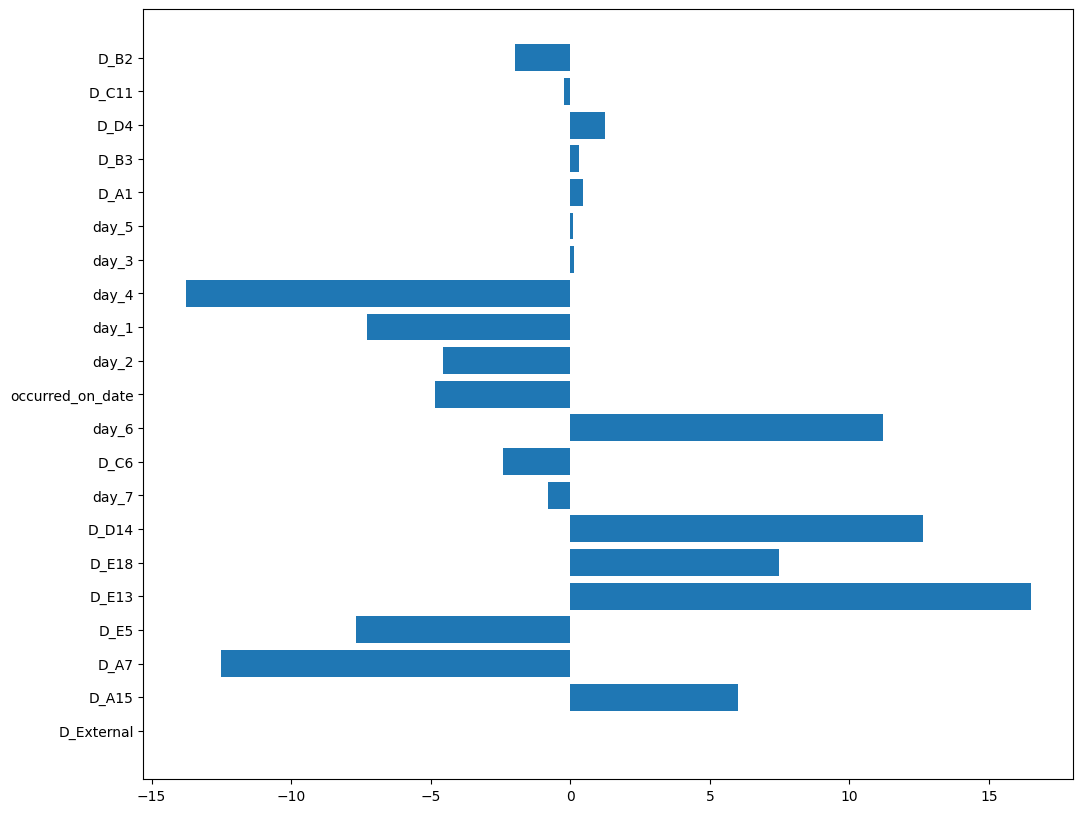

In [157]:
plt.figure(figsize=(12, 10))
importances = lr.coef_
indices = np.argsort(importances)
plt.barh([x for x in range(len(importances))], importances)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

In [158]:
xgb = XGBRegressor(n_estimators = 200).fit(x_train, y_train)
pred = xgb.predict(x_test)
print(r2_score(y_test, pred))

0.5937286492993276


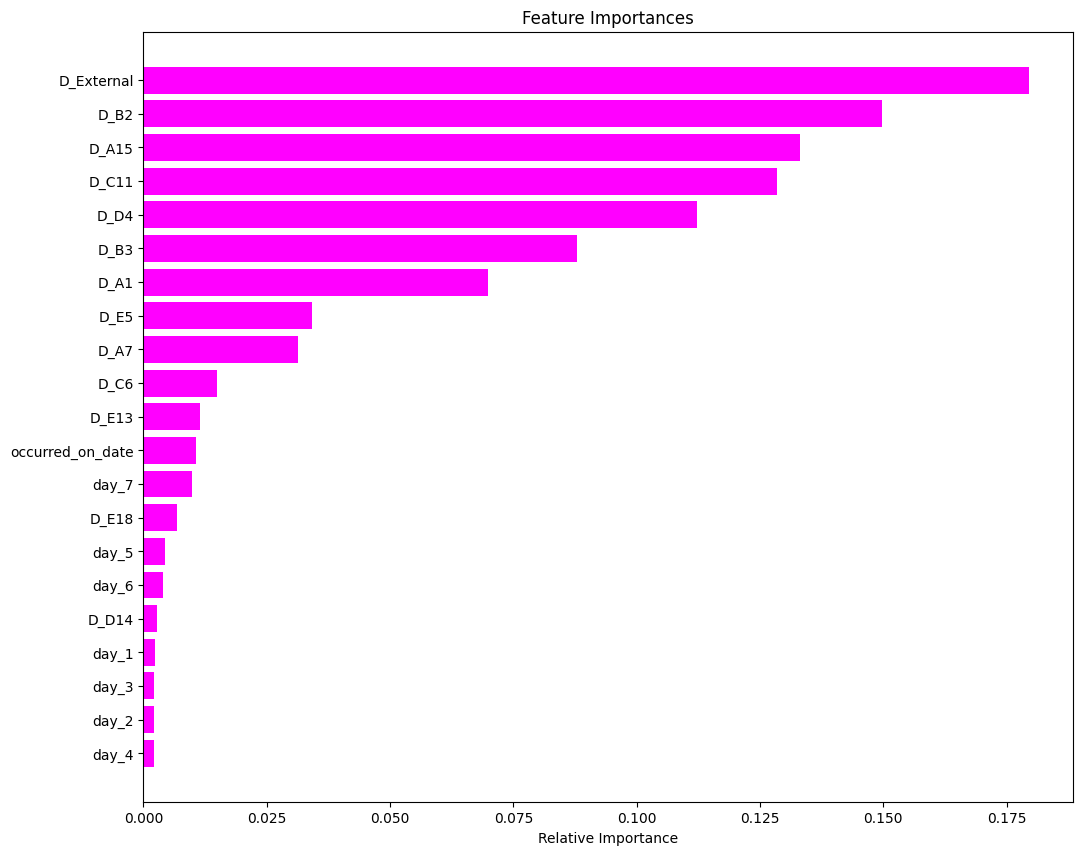

In [160]:
feature_names = list(x.columns)
importances = xgb.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12, 10))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="magenta", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [161]:
lgbm = LGBMRegressor(n_estimators = 200).fit(x_train, y_train)
pred = lgbm.predict(x_test)
print(r2_score(y_test, pred))

0.5181966894389892


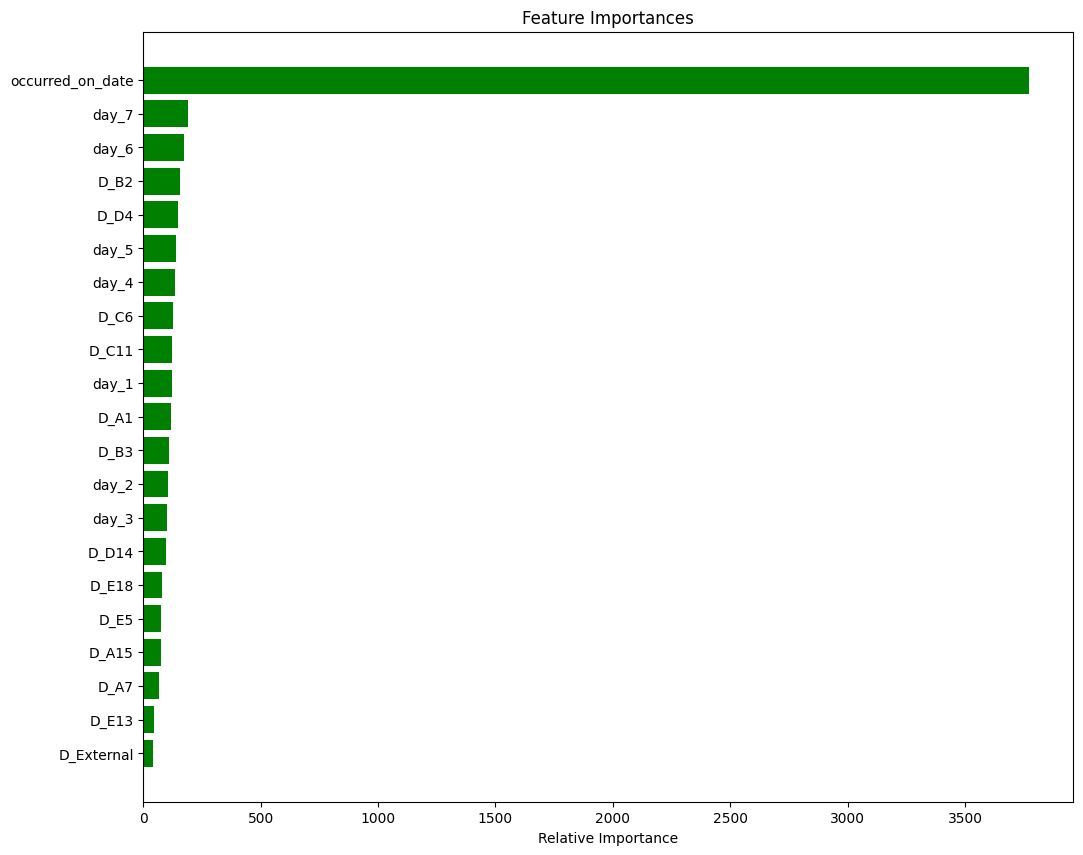

In [162]:
feature_names = list(x.columns)
importances = lgbm.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12, 10))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [163]:
rfr = RandomForestRegressor(n_estimators = 200).fit(x_train, y_train)
pred = rfr.predict(x_test)
print(r2_score(y_test, pred))

0.5810071618579906


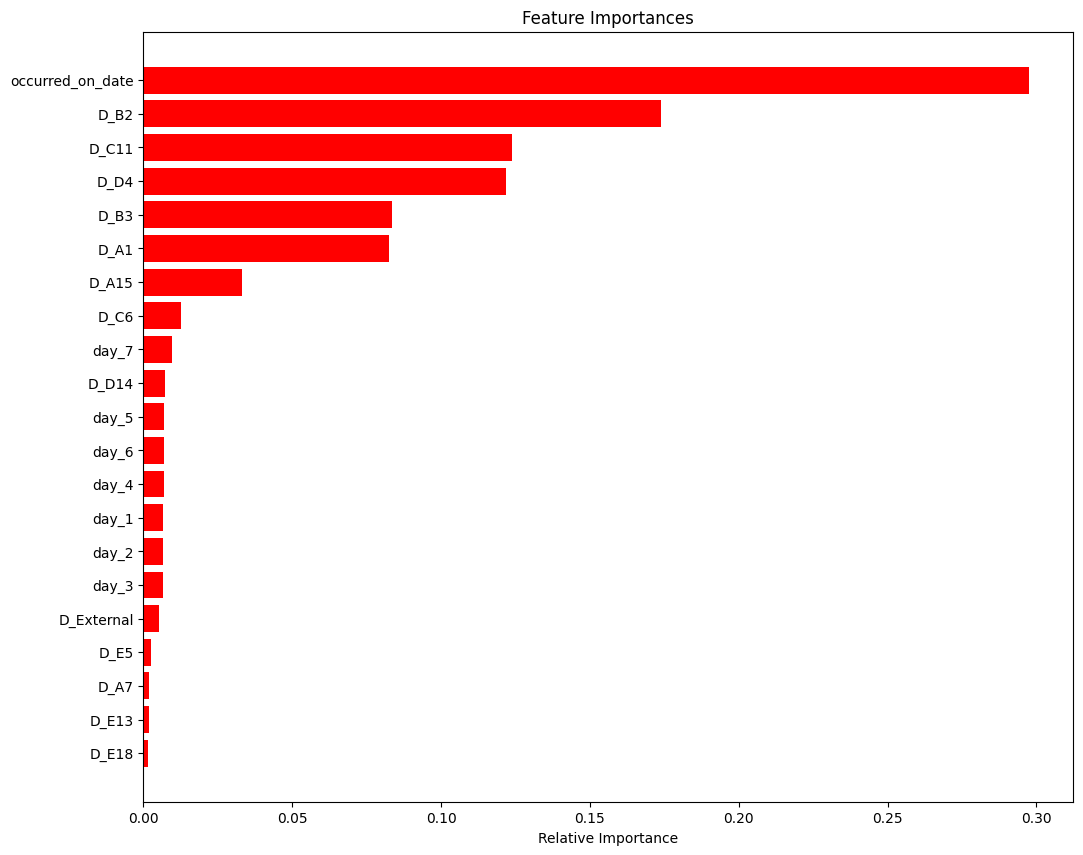

In [164]:
feature_names = list(x.columns)
importances = rfr.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12, 10))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="red", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [169]:
algo_accuracy = pd.DataFrame({"Algorithms":["LinearRegression", "XGBRegressor", "LGBMRegressor", "RandomForestRegressor"], "r2_score":[0.413,0.593, 0.518, 0.589]})

In [190]:
algo_accuracy.sort_values(by = 'r2_score', ascending = False, inplace = True)

In [191]:
algo_accuracy

,Algorithms,r2_score
1,XGBRegressor,0.593
3,RandomForestRegressor,0.589
2,LGBMRegressor,0.518
0,LinearRegression,0.413


# Hyperparameter
## RandomizedSearchCV

In [174]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
import optuna
from tpot import TPOTRegressor

In [181]:
xgb = XGBRegressor(n_jobs = -1)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14, 20, 22]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8, 16, 32]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
rscv = RandomizedSearchCV(xgb, random_grid, n_iter = 50, cv = 3, verbose = 2).fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[14:41:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END criterion=entropy, max_depth=340, max_features=log2, min_samples_leaf=2, min_samples_split=22, n_estimators=600; total time=  15.1s
[14:41:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly p

In [183]:
rscv.best_params_

{'n_estimators': 750,
 'min_samples_split': 22,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'entropy'}

In [189]:
xgb = XGBRegressor(n_estimators= 750,
 min_samples_split= 22,
 min_samples_leaf= 1,
 max_features = 'auto',
 max_depth = 10,
 criterion = 'entropy').fit(x_train, y_train)
pred = xgb.predict(x_test)
print(r2_score(y_test, pred))

[15:33:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.6482648397762744


## GridSearchCV 

In [ ]:
params = {'n_estimators': [rscv.best_params_['n_estimators']+5, 
                          rscv.best_params_['n_estimators']+2,
                          rscv.best_params_['n_estimators']-5,
                          rscv.best_params_['n_estimators']+10],
               'max_features': ['auto', 'sqrt','log2'],
               'max_depth': [rscv.best_params_['max_depth']+2, 
                            rscv.best_params_['max_depth']+3,
                            rscv.best_params_['max_depth']-2,
                            rscv.best_params_['max_depth']-3],
               'min_samples_split': [rscv.best_params_['min_samples_split']+2,
                                    rscv.best_params_['min_samples_split']+3,
                                    rscv.best_params_['min_samples_split']-3,],
               'min_samples_leaf': [rscv.best_params_['min_samples_leaf']+2,
                                   rscv.best_params_['min_samples_leaf']+4,
                                   rscv.best_params_['min_samples_leaf']-1,
                                   rscv.best_params_['min_samples_leaf']-2],
              'criterion':['entropy']}
xgb = XGBRegressor(n_jobs = -1, tree_method = 'gpu_hist')
gscv = GridSearchCV(xgb, params, scoring = 'r2', cv = 20).fit(x_train, y_train)
gscv.best_params_

[16:09:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:09:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:10:56] WARNING: C:/Users/administrator/workspa

In [ ]:
xgb = XGBRegressor().fit(x_train, y_train)
pred = xgb.predict(x_test)
print(r2_score(y_test, pred))

In [ ]:
pickle.dump(xgb, open('XGBmodel.pkl', 'wb'))

In [129]:
df_reg.shape

(31835, 16)

In [199]:
from sklearn import metrics
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [194]:
acc_after_HT = pd.DataFrame({"HP_techniques" : ['RandomizedSearchCV', 'GridSearchCV', 'Genetic_Algorithm', 'Optuna'], 
                             'XGB_r2_score' : [0.6482, 0, 0, 0]})

In [193]:
acc_after_HT

,HP_techniques,XGB_r2_score
0,RandomizedSearchCV,0.6482
1,GridSearchCV,0.0000
2,Genetic_Algorithm,0.0000
3,Optuna,0.0000


In [129]:
df_reg.shape

(31835, 16)

In [69]:
for i in x.columns:
    if df[i].nunique() > 2 and df[i].nunique() < 15:
        df[i] = df[i].astype('category')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21116 entries, 0 to 21115
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   incident_number             21116 non-null  object  
 1   offense_code                21116 non-null  category
 2   offense_code_group          21116 non-null  object  
 3   offense_description         21116 non-null  object  
 4   district                    21116 non-null  category
 5   reporting_area              21116 non-null  object  
 6   shooting                    21116 non-null  int64   
 7   occurred_on_date            21116 non-null  object  
 8   year                        21116 non-null  category
 9   month                       21116 non-null  category
 10  day_of_week                 21116 non-null  category
 11  hour                        21116 non-null  int64   
 12  ucr_part                    21116 non-null  object  
 13  street          

In [32]:
len(df.offense_code.unique())

4

In [72]:
df.drop(['incident_number', 'offense_code_group', 'offense_description', 'occurred_on_date', 'street', 'location'], axis = 1, inplace = True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21116 entries, 0 to 21115
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   offense_code                21116 non-null  category
 1   district                    21116 non-null  category
 2   reporting_area              21116 non-null  object  
 3   shooting                    21116 non-null  int64   
 4   year                        21116 non-null  category
 5   month                       21116 non-null  category
 6   day_of_week                 21116 non-null  category
 7   hour                        21116 non-null  int64   
 8   ucr_part                    21116 non-null  object  
 9   lat                         21116 non-null  float64 
 10  long                        21116 non-null  float64 
 11  season                      21116 non-null  category
 12  avg_high_temp (C)           21116 non-null  category
 13  avg_low_temp (C)

In [33]:
"""data_profile = pandas_profiling.ProfileReport(df)
data_profile.to_file(output_file = 'final_Data_Profile.html')"""


"data_profile = pandas_profiling.ProfileReport(df)\ndata_profile.to_file(output_file = 'final_Data_Profile.html')"

In [115]:
new_df = copy.deepcopy(df)

In [35]:
new_df = new_df[['offense_code', 'district', 'shooting', 'month', 'day_of_week', 'hour', 'ucr_part', 'lat', 'long']]

In [36]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21116 entries, 0 to 21115
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   offense_code  21116 non-null  object 
 1   district      21116 non-null  object 
 2   shooting      21116 non-null  int64  
 3   month         21116 non-null  int64  
 4   day_of_week   21116 non-null  object 
 5   hour          21116 non-null  int64  
 6   ucr_part      21116 non-null  object 
 7   lat           21116 non-null  float64
 8   long          21116 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 1.5+ MB


In [37]:
df['ucr_part'].dtype

dtype('O')

In [38]:
enc = le()
for i in new_df.columns:
    if new_df[i].dtype == 'O':
        new_df[i] = enc.fit_transform(df[i])

In [50]:
new_df

,offense_code,district,shooting,month,day_of_week,hour,ucr_part,lat,long
0,0,8,0,12,5,12,3,42.342432,-71.072258
1,0,10,0,12,5,12,3,42.268897,-71.108137
2,0,3,0,12,5,12,3,42.323410,-71.093396
3,0,4,0,12,5,0,3,42.279971,-71.095534
4,3,2,0,12,5,0,1,42.370818,-71.039291
...,...,...,...,...,...,...,...,...,...
21111,1,0,0,1,2,1,2,42.359330,-71.053550
21112,3,0,0,1,2,0,1,42.360688,-71.056873
21113,0,11,0,1,2,0,3,42.292092,-71.121089
21114,3,8,0,1,2,0,1,42.346251,-71.099539


<AxesSubplot:>

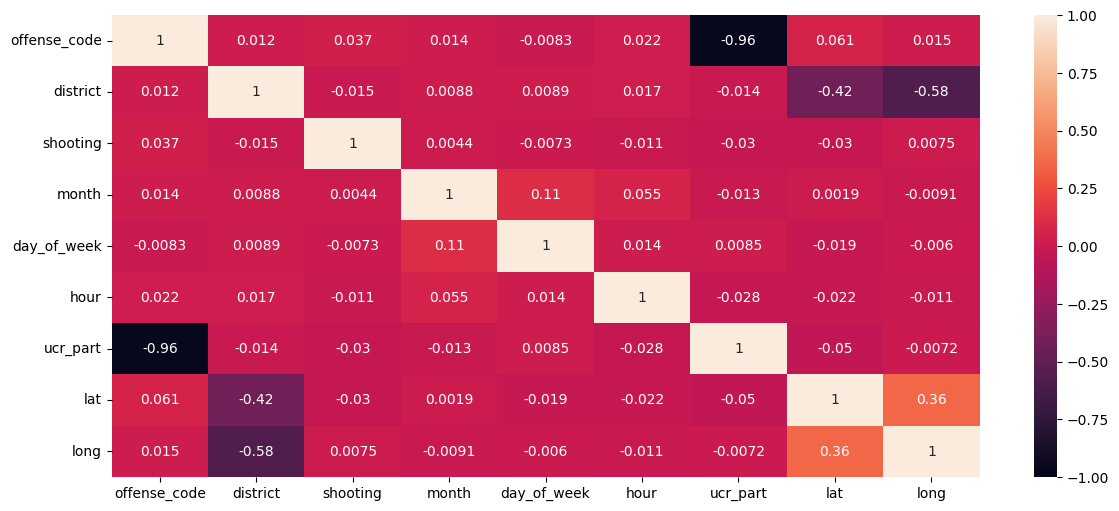

In [40]:
plt.figure(figsize = (14,6))
sb.heatmap(new_df.corr(), vmin = -1, vmax = 1, annot = True)

In [41]:
x = new_df.drop('ucr_part', axis = 1)
y = new_df['ucr_part']

In [42]:
x_train, x_test, y_train, y_test = tts(x,y, test_size = 0.25)

In [43]:
y_train.value_counts()

2    7838
3    5028
1    2917
0      54
Name: ucr_part, dtype: int64

In [44]:
over_sample = SMOTE(n_jobs = -1)
x_train,y_train= over_sample.fit_resample(x_train,y_train)

In [45]:
dtc = DecisionTreeClassifier().fit(x_train, y_train)
pred = dtc.predict(x_test)
pred

array([3, 2, 2, ..., 1, 1, 2])

In [46]:
print(cr(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00       972
           2       1.00      1.00      1.00      2601
           3       1.00      1.00      1.00      1689

    accuracy                           1.00      5279
   macro avg       1.00      1.00      1.00      5279
weighted avg       1.00      1.00      1.00      5279



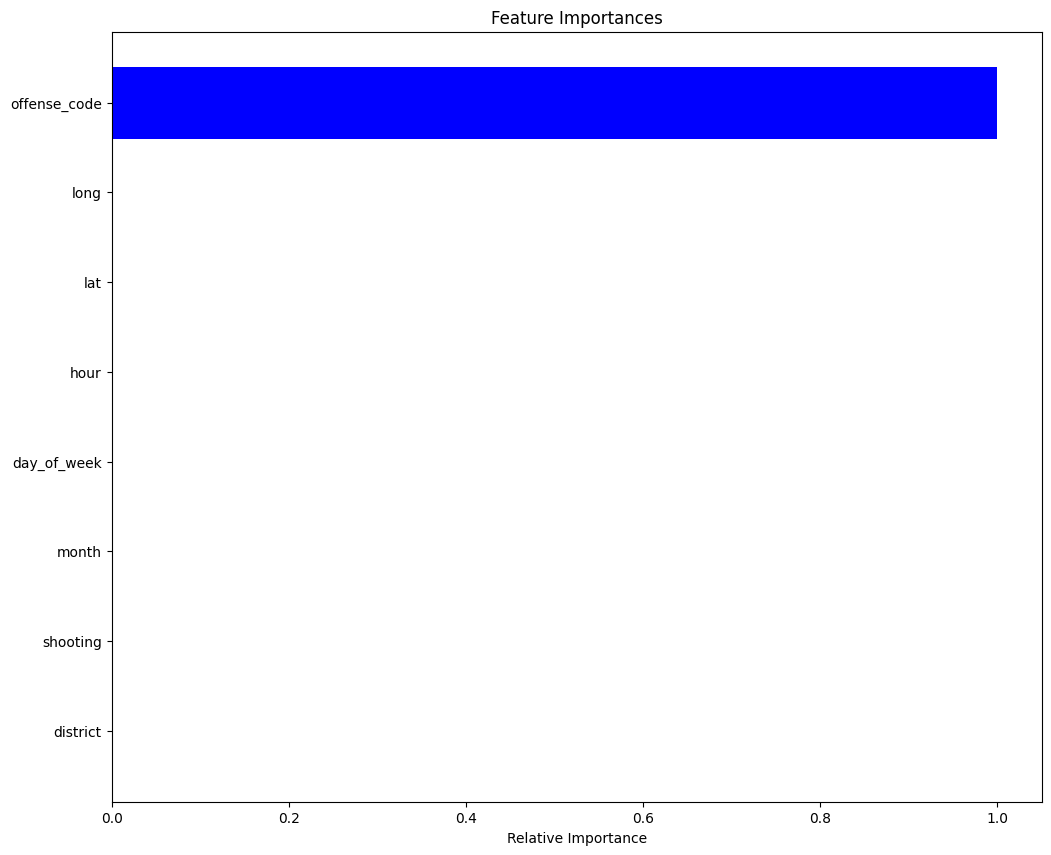

In [47]:
feature_names = list(x.columns)
importances = dtc.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12, 10))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="blue", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [48]:
from sklearn.feature_selection import VarianceThreshold

In [49]:
selector = VarianceThreshold()
selector.fit_transform(x_train)

array([[  0.        ,   5.        ,   0.        , ...,  16.        ,
         42.30839354, -71.06473124],
       [  0.        ,   4.        ,   0.        , ...,  11.        ,
         42.29276044, -71.07486603],
       [  1.        ,   3.        ,   0.        , ...,  10.        ,
         42.32866284, -71.08563401],
       ...,
       [  0.        ,   9.        ,   0.        , ...,  15.        ,
         42.31603034, -71.09781673],
       [  0.        ,  11.        ,   0.        , ...,  12.        ,
         42.28721378, -71.14757726],
       [  0.        ,   2.        ,   0.        , ...,   9.        ,
         42.34117031, -71.0847324 ]])